In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/repos/YOLOv3/


/content/drive/MyDrive/repos/YOLOv3


In [3]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
from pathlib import Path


In [4]:
# plot bounding box
def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    import random
    import colorsys

    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_bboxes(image_path, bboxes, labels=[], ax=None, figsize=(8, 8), readfits=False, title=None,
                colors=None):
    """
    Draw bounding boxes on image
    img: img array
    bboxes: bounding boxes array, shape [n bboxes, 4]
    """
    import cv2
    import random
    import matplotlib.pyplot as plt
    from matplotlib import patches
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
    
    N = bboxes.shape[0]
    if colors == None:
        colors = random_colors(N)
    else: 
        colors = [colors]*N

    if readfits:
        fitspath = image_path.replace("jpg", "fits.npz")
        image_data = np.load(fitspath)["fitsarr"]
        print(fitspath)
        original_image = fits_to_uint8(image_data, vmin=-1, vmax=1)
        ax.imshow(original_image)

    elif image_path:
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)    
        #image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
        ax.imshow(original_image)
    
    ax.set_title(title)
    for i in range(N):
        # for faster rcnn
        #y1, x1, y2, x2 = bboxes[i] [:4]
        #y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)

        # for yolo
        x1, y1, x2, y2 = bboxes[i][:4]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=colors[i], facecolor='none')
        ax.add_patch(p)
        
        # Label
        #class_id = class_ids[i]
        #score = scores[i] if scores is not None else None
        #label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{:.2f}".format( labels[i] )
        ax.text(x2 - 8, y1, caption,
                color='w', size=10, backgroundcolor="none")



In [5]:
def draw_boxes(bboxes, labels=[], ax=None, colors=None):
    """draw bounding box on a given ax"""
    import random
    import matplotlib.pyplot as plt
    from matplotlib import patches
 
    N = bboxes.shape[0]    
    if colors == None:
        colors = random_colors(N)
    else: 
        colors = [colors]*N

    for i in range(N):
        # for faster rcnn
        #y1, x1, y2, x2 = bboxes[i] [:4]
        #y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)    
        # for yolo
        x1, y1, x2, y2 = bboxes[i][:4]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=colors[i], facecolor='none')
        ax.add_patch(p)

        # Label
        #class_id = class_ids[i]
        #score = scores[i] if scores is not None else None
        #label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{:.2f}".format( labels[i] )
        ax.text(x2 - 8, y1, caption,
                color='w', size=10, backgroundcolor="none") 
    



In [6]:
thecbases = [plt.cm.Blues,
             plt.cm.Greens,
             plt.cm.Purples,
             plt.cm.Reds,
             plt.cm.YlOrBr,
             (240./255,230./255,140./255, 1.),
            ]
grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]

#thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
#                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
#                     for i in range(5)] + [thecbases[5]]}

thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
            'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
pairs = 'same'
COLORS = np.vstack( [c for c in thecmaps[pairs]] )

In [7]:
def plot_pr(df_pred, classid=0, saveto=None, colors=COLORS, ax=None, title=None):
    """plot pr curve on given ax"""
    if ax==None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5,]

    SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]
    cls_idx = df_pred['classid']==classid
    scores_pred = np.concatenate( df_pred[cls_idx] ['score_pred'].values )
    ious_pred = np.concatenate( df_pred[cls_idx]['iou_pred'].values )
    ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
    
    #scores_ann = np.concatenate( df_pred[cls_idx]['score_ann'].values )
    objids_pred = np.concatenate(df_pred[cls_idx]['objid_pred'].values)
    
    #nAnn = len(ious_ann)
    nAnn = len( np.concatenate( df_pred[cls_idx]['label_ann'].values ) )

    #x = np.linspace(0, 800, 10)

    for i, iou_th in enumerate(IOU_THs):
        nTPs = []
        nFPs = []
        precision = []
        recall = []
        for score_th in SCORE_THs:
            # idx_s = scores > score_th
            nDet = np.sum( scores_pred > score_th )
            ious_det_pred = ious_pred [ scores_pred > score_th ]
            #ious_det_ann = ious_ann [ scores_ann > score_th ]
            objids_det = objids_pred[ scores_pred > score_th ]

            nTP_pred = np.sum( ious_det_pred > iou_th )
            objids_TP = objids_det[ ious_det_pred > iou_th ]
            #nTP_ann = np.sum( ious_det_ann > iou_th )
            nTP_ann = len( np.unique(objids_TP[objids_TP!=-1] ) )
            #nTP = np.min([nTP_pred, nTP_ann])
            nFP = nDet - nTP_pred
            nTPs.append(nTP_ann)
            nFPs.append(nFP)

            p = nTP_pred/nDet
            r = nTP_ann/nAnn
            precision.append(p)
            recall.append(r)
            #print("iou_th:{},score_th:{}, nDet:{}, nTP:{}, nFP:{}".format(iou_th, score_th, nDet, nTP_ann, nFP))
            #ax1.text(nFP, nTP_ann, score_th)
            if iou_th==0:
                ax.text(r, p, score_th);

        #print(iou_th, precision, recall )

        ax.plot(recall, precision,'.-', label='iou>{}'.format(iou_th), color=COLORS[i] );

    #ax.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
    #ax.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )

    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.set_xlim([0, 1.1])
    ax.set_ylim([0, 1.1])

    ax.set_title( title )
    plt.legend(loc='lower left')
    ax.grid('on')
    if saveto!=None:
        fig.savefig(fname=saveto)
    #matplotlib.pyplot.close(fig)

    

In [8]:
def plot_roc_pr_curve(df_pred, classid=0, saveto=None, colors=COLORS):
    """plot roc/pr curve """
    #df_pred = pd.read_pickle("./log_niou/df_pred_niou_v5_testset.pickle")

    fig, axs = plt.subplots(1, 3, figsize=(19, 5))
    axs = axs.flatten()

    #IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]
    
    IOU_THs = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5,]

    SCORE_THs = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8, 0.9]
    cls_idx = df_pred['classid']==classid
    scores_pred = np.concatenate( df_pred[cls_idx] ['score_pred'].values )
    ious_pred = np.concatenate( df_pred[cls_idx]['iou_pred'].values )
    ious_ann = np.concatenate( df_pred[cls_idx]['iou_ann'].values )
    
    #scores_ann = np.concatenate( df_pred[cls_idx]['score_ann'].values )
    objids_pred = np.concatenate(df_pred[cls_idx]['objid_pred'].values)
    
    #nAnn = len(ious_ann)
    nAnn = len( np.concatenate( df_pred[cls_idx]['label_ann'].values ) )

    ax = axs[0]

    ax.scatter(scores_pred[ious_pred==0], ious_pred[ious_pred==0], 
               facecolor='none', edgecolor=colors[0], s=15, alpha=0.5, label='')
    ax.scatter(scores_pred[ious_pred!=0], ious_pred[ious_pred!=0], 
               facecolor=colors[0], s=15, alpha=0.5, label='')
    #ax.scatter(scores_ann, ious_ann, s=10, alpha=0.8, )
    ax.plot(np.linspace(0, 1, 10), 0.1*np.ones(10), 'k' , linewidth=0.5)
    ax.plot(0.1*np.ones(10), np.linspace(0, 1, 10), 'k' , linewidth=0.5)
    ax.set_xlabel("score")
    ax.set_ylabel("iou")

    ax1 = axs[1]
    ax2 = axs[2]

    x = np.linspace(0, 800, 10)
    ax1.plot(x, x , 'k-', label=' TP/FP = 1', )
    ax1.plot(x, 1/5 *x , 'k--', label=' TP/FP = 1/5', )
    ax1.plot(x, 1/10 *x , 'k-.', label=' TP/FP = 1/10', )

    for i, iou_th in enumerate(IOU_THs):
        nTPs = []
        nFPs = []
        precision = []
        recall = []
        for score_th in SCORE_THs:
            # idx_s = scores > score_th
            nDet = np.sum( scores_pred > score_th )
            ious_det_pred = ious_pred [ scores_pred > score_th ]
            #ious_det_ann = ious_ann [ scores_ann > score_th ]
            objids_det = objids_pred[ scores_pred > score_th ]

            nTP_pred = np.sum( ious_det_pred > iou_th )
            objids_TP = objids_det[ ious_det_pred > iou_th ]
            #nTP_ann = np.sum( ious_det_ann > iou_th )
            nTP_ann = len( np.unique(objids_TP[objids_TP!=-1] ) )
            #nTP = np.min([nTP_pred, nTP_ann])
            nFP = nDet - nTP_pred
            nTPs.append(nTP_ann)
            nFPs.append(nFP)

            p = nTP_pred/nDet
            r = nTP_ann/nAnn
            precision.append(p)
            recall.append(r)
            #print("iou_th:{},score_th:{}, nDet:{}, nTP:{}, nFP:{}".format(iou_th, score_th, nDet, nTP_ann, nFP))
            #ax1.text(nFP, nTP_ann, score_th)
            if iou_th==0:
                ax2.text(r, p, score_th)

        #print(iou_th, precision, recall )

        ax2.plot(recall, precision,'.-', label='iou>{}'.format(iou_th), color=COLORS[i] )
        nFPs = np.array(nFPs)
        nTPs = np.array(nTPs)
        ax1.plot(nFPs[nFPs>0], nTPs[nFPs>0], '.-', label='iou>{}'.format(iou_th), color=COLORS[i])

    #ax.plot(x,  1./5*df.loc[iou, :].nFP.values/ 156, 'k--', label='TP/FP = 1/5'.format(iou), )
    #ax.plot(x,  1./10*df.loc[iou, :].nFP.values/ 156, 'k-.', label='TP/FP =  1/10'.format(iou), )
    ax1.legend(['TP/FP=1','TP/FP=1/5','TP/FP=1/10'],loc='lower right')

    ax1.set_xlabel("FP")
    ax1.set_ylabel("TP")
    ax1.set_xlim([0, 800])
    ax1.set_ylim([0, nAnn])
    #ax1.set_xscale('log')

    ax2.set_xlabel("recall")
    ax2.set_ylabel("precision")
    ax2.set_xlim([0, 1.1])
    ax2.set_ylim([0, 1.1])
    plt.legend(loc='lower left')

    if saveto!=None:
        fig.savefig(fname=saveto)
    #matplotlib.pyplot.close(fig)



### plot

In [ ]:
Path("../YOLOv3/log_df/df_pred_iop_model_miou_v1_ep16_testset_largebox.pickle").is_file()

True

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

axs = axs.flatten()

for i in range(2, 100, 2):

    pkfile =  f"../YOLOv3/log_df/df_pred_iop_model_miou_v1_ep{i}_testset_largebox.pickle"

    if Path(pkfile).is_file():
        df_pred = pd.read_pickle(pkfile)
        plot_pr(df_pred, classid=0, ax=axs[i]);


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
No handles with labels foun

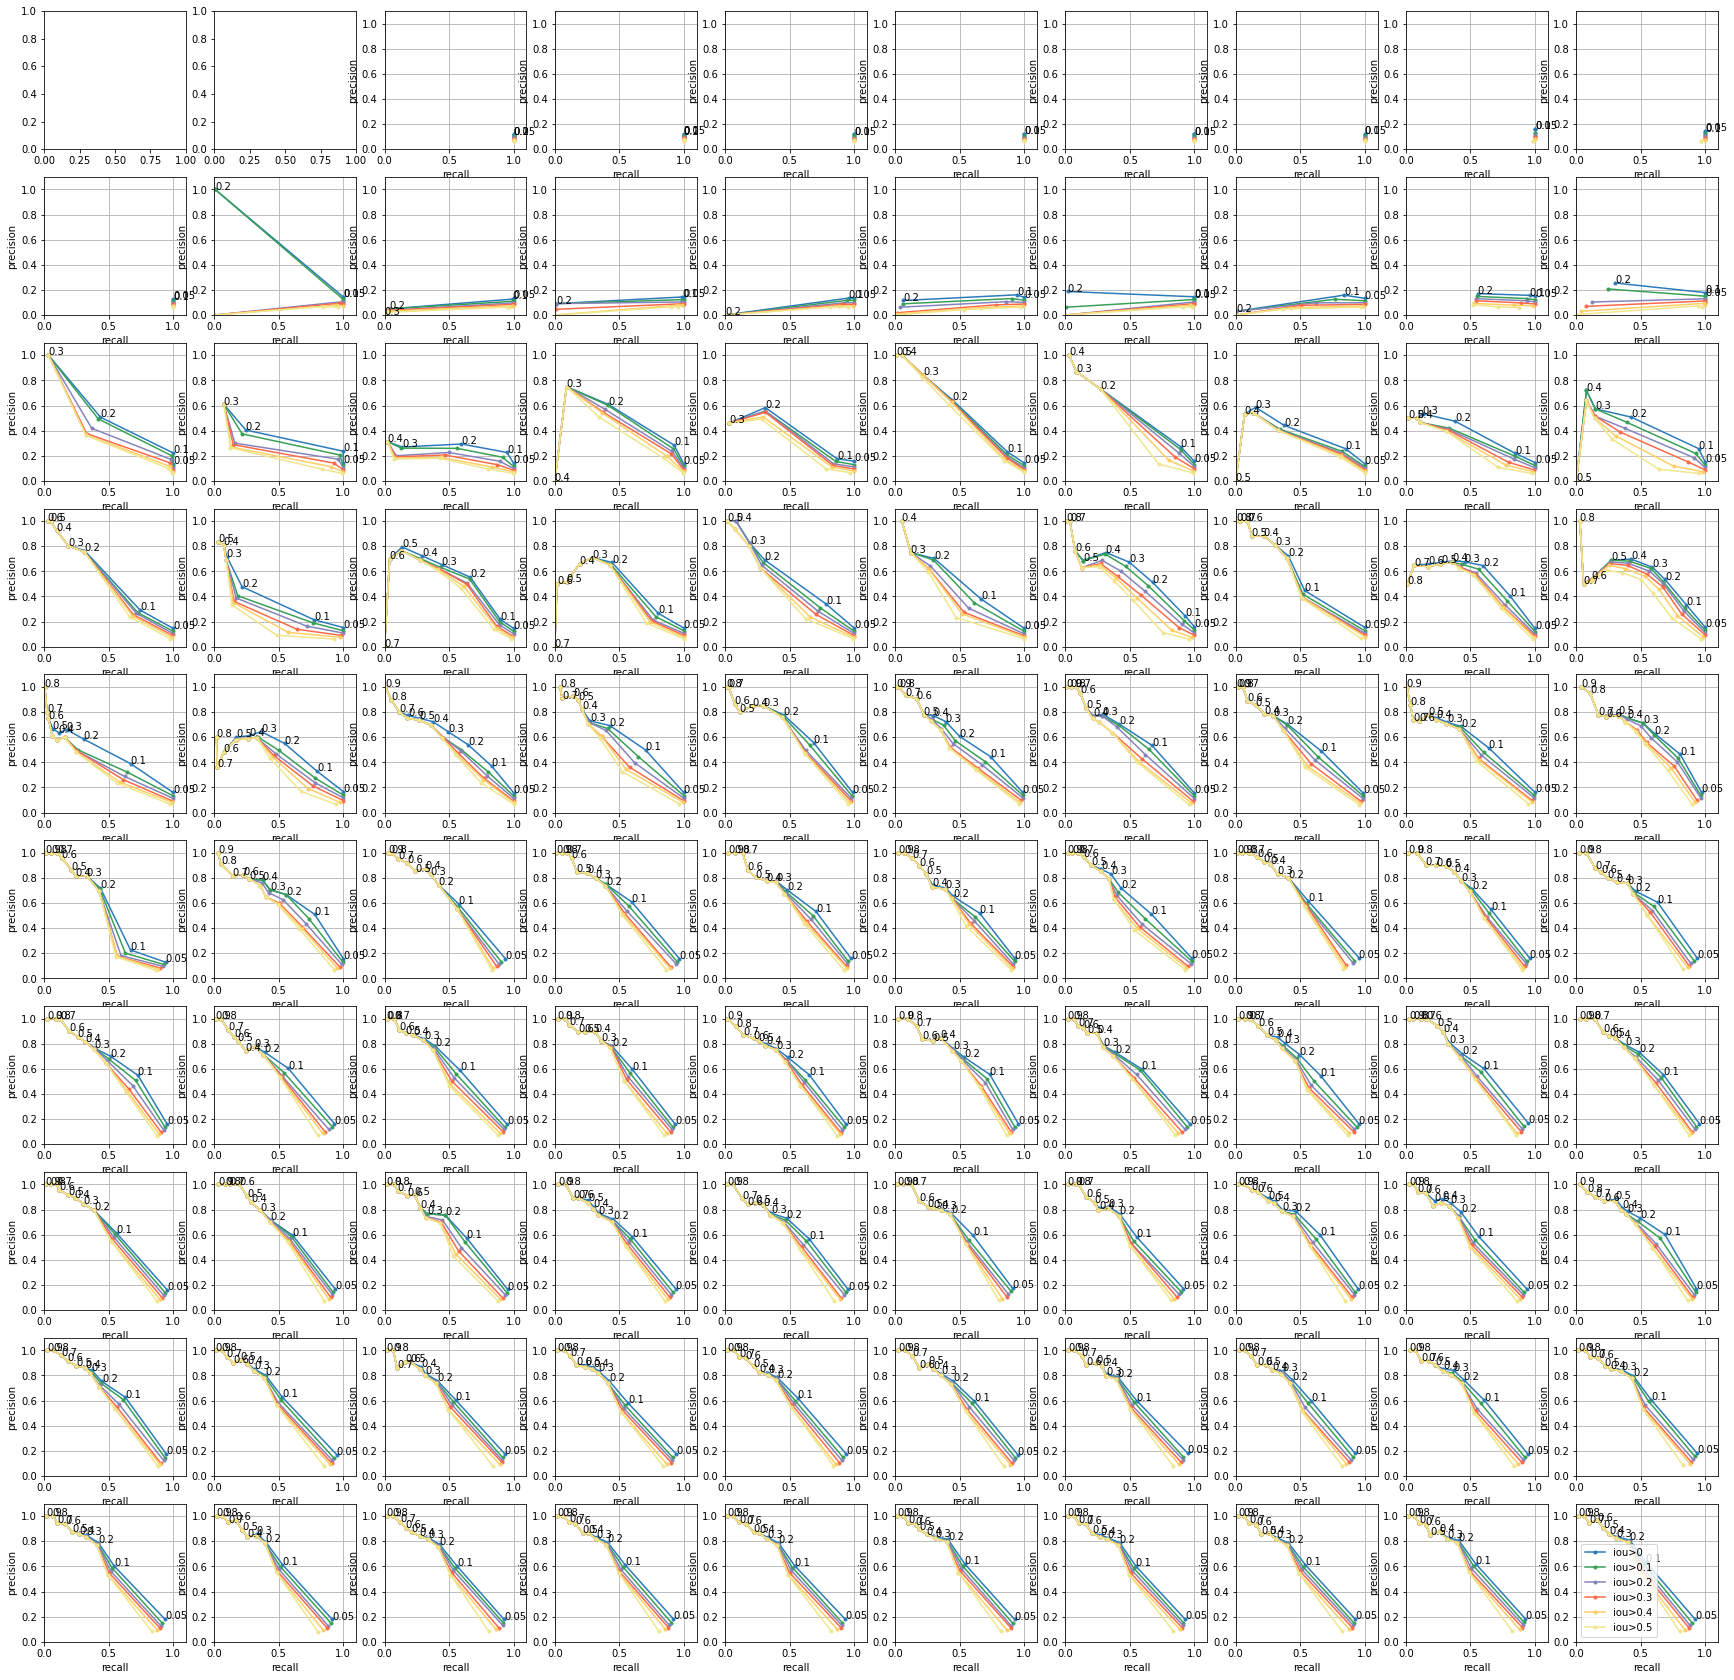

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

axs = axs.flatten()

for i in range(2, 100, 1):
    df_pred = pd.read_pickle(f"../YOLOv3/log_df/df_pred_iop_model_miou_train_aug2_ep{i}_testset_largebox.pickle")
    plot_pr(df_pred, classid=0, ax=axs[i]);


In [ ]:
df_pred_yolov3_miou_v1 = pd.read_pickle("./log_df/df_pred_iop_model_miou_v1_ep50_testset_largebox.pickle")

df_pred_yolov3_miou_v2 = pd.read_pickle("./log_df/df_pred_iop_model_miou_v")


No handles with labels found to put in legend.
No handles with labels found to put in legend.


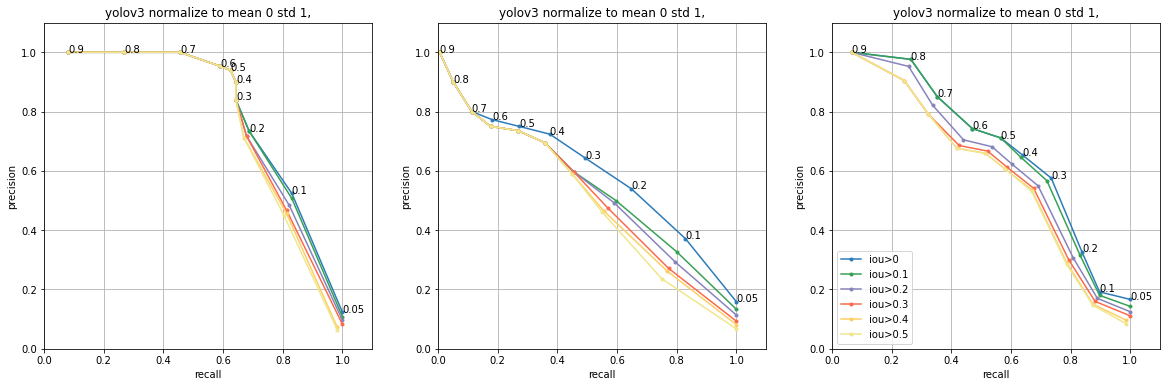

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()

df_pred_yolov3_miou_v1 = pd.read_pickle("../YOLOv3/log_df/df_pred_iop_model_miou_v1_ep42_testset_largebox.pickle")
plot_pr(df_pred_yolov3_miou_v1, classid=0, ax=axs[0])
axs[0].set_title('yolov3 normalize to mean 0 std 1,')
axs[0].grid('on');

df_pred_yolov3_miou_train_aug2 = pd.read_pickle("../YOLOv3/log_df/df_pred_iop_model_miou_train_aug2_ep42_testset_largebox.pickle")
plot_pr(df_pred_yolov3_miou_train_aug2, classid=0, ax=axs[1])
axs[1].set_title('yolov3 normalize to mean 0 std 1,')
axs[1].grid('on');

df_pred_yolov3_miou_train_aug3 = pd.read_pickle("../YOLOv3/log_df/df_pred_iop_model_miou_train_aug3_ep43_testset_largebox.pickle")
plot_pr(df_pred_yolov3_miou_train_aug3, classid=0, ax=axs[2])
axs[2].set_title('yolov3 normalize to mean 0 std 1,')
axs[2].grid('on');


#df_pred_yolov5 = pd.read_pickle("../YOLOv5/yolov5/runs/eval/exp17/df_pred_iop_epoch100_testset_largebox.pickle")
#
#plot_pr(df_pred_yolov5, classid=0, ax=axs[2])
#
#axs[2].set_title('yolov5 normalization,')
#
#plt.grid('on');

pr vs epoch

In [ ]:
# get nTP
def get_nAnn(df_pred):
    """get number of Ann box"""
    nAnn = len( df_pred["label_ann"] )
    return nAnn

def get_nDet(df_pred, score_th=0.1):
    """get nDet for score > score_th"""
    nDet = np.sum( df_pred["score_pred"] > score_th )
    return nDet

def get_nTP_pred(df_pred, score_th=0.1, iou_th=0.1):
    """get nTP pred, used to calculate precision """
    ious_pred = df_pred['iou_pred']
    scores_pred = df_pred['score_pred']
    objids_pred = df_pred['objid_pred']

    ious_det_pred = ious_pred [ scores_pred > score_th ]
    #ious_det_ann = ious_ann [ scores_ann > score_th ]
    #objids_det = objids_pred[ scores_pred > score_th ]

    nTP_pred = np.sum( ious_det_pred > iou_th )
    return nTP_pred

def get_nTP_ann(df_pred, score_th=0.1, iou_th=0.1):
    """get nTP ann, used to calculate recall"""
    ious_pred = df_pred['iou_pred']
    scores_pred = df_pred['score_pred']
    objids_pred = df_pred['objid_pred']

    ious_det_pred = ious_pred [ scores_pred > score_th ]
    #ious_det_ann = ious_ann [ scores_ann > score_th ]
    objids_det = objids_pred[ scores_pred > score_th ]

    #nTP_pred = np.sum( ious_det_pred > iou_th )
    objids_TP = objids_det[ ious_det_pred > iou_th ]
    #nTP_ann = np.sum( ious_det_ann > iou_th )
    nTP_ann = len( np.unique(objids_TP[objids_TP!=-1] ) )
    return nTP_ann


In [ ]:
def get_pr(df, classid, score_th = 0.2, iou_th = 0):
    """return precision and recall"""
    df = df[df.classid==classid].sort_values(by='img', inplace=False, ignore_index=True)
    df[f'nDet_s{score_th}'] = df.apply(get_nDet, args=(score_th,), axis=1, )
    df[f'nTP_pred_s{score_th}_i{iou_th}'] = df.apply(get_nTP_pred, args=(score_th, iou_th), axis=1, )
    df[f'nTP_ann_s{score_th}_i{iou_th}'] = df.apply(get_nTP_ann, args=(score_th, iou_th), axis=1, )

    nTP_pred = df[f'nTP_pred_s{score_th}_i{iou_th}'].sum()
    nTP_ann = df[f'nTP_ann_s{score_th}_i{iou_th}'].sum()
    nDet = df[f'nDet_s{score_th}'].sum()
    nAnn = df[f'nAnn'].sum()

    p = nTP_pred / nDet
    r = nTP_ann / nAnn

    return p, r

In [ ]:

def get_ep_pr_f1(model='yolo3 v1', classid=0, score_th=0.2, iou_th=0, ioutype='iop'):
    """get pr and f1 """
    epoch = []
    precision = []
    recall = []
    f1 = []
    for ep in range(0, 200):
        pk_dic = {
                'yolo3 v1' : f"../YOLOv3/log_df/df_pred_{ioutype}_model_miou_v1_ep{ep}_testset_largebox.pickle",
                'yolo3 v2' : f"../YOLOv3/log_df/df_pred_{ioutype}_model_miou_v2_ep{ep}_testset_largebox.pickle",

                'yolo3 aug2' : f"../YOLOv3/log_df/df_pred_{ioutype}_model_miou_train_aug2_ep{ep}_testset_largebox.pickle",
                'yolo3 aug3' : f"../YOLOv3/log_df/df_pred_{ioutype}_model_miou_train_aug3_ep{ep}_testset_largebox.pickle",

                'yolo3 aug2 range01' : f"../YOLOv3/log_df/df_pred_{ioutype}_model_miou_train_aug2_range01_ep{ep}_testset_largebox.pickle",
                'yolo3 aug3 range01' : f"../YOLOv3/log_df/df_pred_{ioutype}_model_miou_train_aug3_range01_ep{ep}_testset_largebox.pickle",

                'yolo5 exp15' : f"../YOLOv5/yolov5/runs/eval/exp15/df_pred_{ioutype}_epoch{ep}_testset_largebox.pickle",
                'yolo5 exp16' : f"../YOLOv5/yolov5/runs/eval/exp16/df_pred_{ioutype}_epoch{ep}_testset_largebox.pickle",
                'yolo5 exp17' : f"../YOLOv5/yolov5/runs/eval/exp17/df_pred_{ioutype}_epoch{ep}_testset_largebox.pickle", 
                
                }

        if Path( pk_dic[model] ).is_file():
            df = pd.read_pickle( pk_dic[model] )
            p, r = get_pr(df, classid, score_th=score_th, iou_th=iou_th)
            f = 2 * p * r / (p + r)
            epoch.append(ep)
            precision.append(p)
            recall.append(r)
            f1.append( f )
            #print(ep, p, r, f)
    
    return epoch, precision, recall, f1



In [ ]:
def plot_ep_pr_f1(ep, p, r, f1, ax=None, title=None):
    """plot precision/recall/f1 score vs epoch"""
    if ax==None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    ax.plot(ep, p, label='precision', color=COLORS[2], linewidth=2, alpha=0.7)
    ax.plot(ep, r, label='recall', color=COLORS[1], linewidth=2, alpha=0.7)
    ax.plot(ep, f1, label='f1 score', color='k', linewidth=2)
    ax.grid('on')
    ax.set_xlabel('epoch')
    ax.set_title( title )
    ax.legend()
    if ax==None:
        return fig


In [ ]:
modelnames = ['yolo3 v1', 'yolo3 aug2' , 'yolo3 aug3' ,
              'yolo3 v2', 'yolo3 aug2 range01', 'yolo3 aug3 range01']

titles = ['yolov3, testset 1, normalize to mean 0, std 1 ', 'yolov3, testset 2, normalize to mean 0, std 1 ', 'yolov3, testset 3, normalize to mean 0, std 1 ',
          'yolov3, testset 1, normalize to range [0, 1] ', 'yolov3, testset 2, normalize to range [0, 1] ','yolov3, testset 3, normalize to range [0, 1] ', ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/li

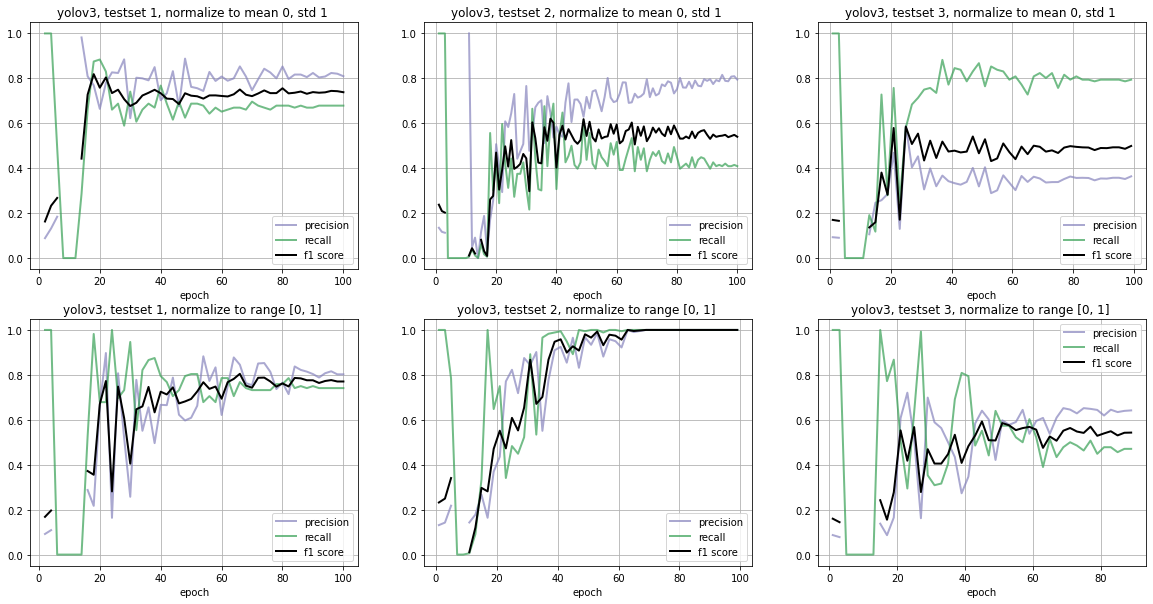

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()

classid = 0
score_th = 0.2
iou_th = 0.0
ioutype = 'miou'

for i in range(6):
    ep, p, r, f1 = get_ep_pr_f1( model=modelnames[i], classid=classid, score_th=score_th, iou_th=iou_th, ioutype=ioutype)
    plot_ep_pr_f1(ep, p, r, f1, ax=axs[i], title=titles[i])

#ep, p, r, f1 = get_ep_pr_f1( model='yolo5 exp15', classid=classid, score_th=score_th, iou_th=iou_th,ioutype=ioutype )
#plot_ep_pr_f1(ep, p, r, f1, ax=axs[2], title='yolo5 clip 1, range[0, 1]')

#ep, p, r, f1 = get_ep_pr_f1( model='yolo5 exp16', classid=classid, score_th=score_th, iou_th=iou_th, ioutype=ioutype)
#plot_ep_pr_f1(ep, p, r, f1, ax=axs[3], title='yolo5 clip 10, mean 0, std 1')

#ep, p, r, f1 = get_ep_pr_f1( model='yolo5 exp17', classid=classid, score_th=score_th, iou_th=iou_th, ioutype=ioutype)
#plot_ep_pr_f1(ep, p, r, f1, ax=axs[4], title='yolo5 clip 1, range[0, 1]')



plot images

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
def get_fig(image_path, df_list, titles,):
    """return a fig to saveto a pdf page
    df_list: [df, df2,...];
    titles: ['title1', 'title2',...]
    """

    fig, axs = plt.subplots(1, len(df_list), figsize=(16, 10) ) 

    for (i, df) in enumerate( df_list ):
        ax = axs[i] if len(df_list)>1 else axs

        idx = df [ (df['classid']==0) & (df['img'] == image_path) ].index[0]
        
        img = image_path.split('/')[-1]
        scores = df['score_pred'][idx]
        bboxes = df['boxes_pred'][idx] [scores>score_th]
        labels = df['score_pred'][idx] [scores>score_th]
        # plot image and predicted boxes
        plot_bboxes(image_path=image_path, bboxes=bboxes, labels=scores, ax=ax, )

        #ax.set_axis_off()
        nAnn = df['nAnn'] [idx]
        nDet = df[f'nDet_s{score_th}'][idx]
        nTP = df[f'nTP_pred_s{score_th}_i{iou_th}'][idx]
        nTP_recall = df[f'nTP_ann_s{score_th}_i{iou_th}'][idx]
        ax.set_title( f''' {titles[i]} 
                     {img}  score>{score_th},
                    nDet={nDet}, nTP={nTP}, nFP={nDet - nTP},
                    nAnn={nAnn}, nRecall={nTP_recall}, nFN={nAnn-nTP_recall}''' )
        bboxes = df['boxes_ann'][idx] 
        labels = df['score_ann'][idx] 
        # plot labeled boxes
        draw_boxes(bboxes, labels=labels, ax=ax, colors='white')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if nTP_recall < nAnn:
            [sp.set_color('r') for sp in ax.spines.values()]
            [sp.set_linewidth(3) for sp in ax.spines.values() ]
    return fig

      

In [ ]:
ls

checkpoints/  eval_yolov3.ipynb  log_df/            train_yolov3.ipynb
dataset@      log/               plot_yolov3.ipynb  yolov3/


In [ ]:
df_v1 = pd.read_pickle("../YOLOv3/log_df/df_pred_iop_model_miou_train_aug2_ep60_testset_largebox.pickle")


#df_train_aug2_range01 = pd.read_pickle("../YOLOv3/log_df/df_pred_iop_model_miou_train_aug2_range01_ep85_testset_largebox.pickle")

#df_train_aug3 = pd.read_pickle("../YOLOv3/log_df/df_pred_iop_model_miou_train_aug3_ep45_testset_largebox.pickle")


In [ ]:
score_th = 0.2
iou_th = 0.0

#df_v3 = df_pred_yolov3_iop_trainset_largebox.copy()
#df_v5 = df_pred_yolov5_iop_trainset_largebox.copy()

#df_v3.sort_values(by='img', inplace=True)
#df_v5.sort_values(by='img', inplace=True)

for df in [df_v1]:
    
    df.sort_values(by='img', inplace=True)

    df[f'nDet_s{score_th}'] = df.apply(get_nDet, args=(score_th,), axis=1, )
    df[f'nTP_pred_s{score_th}_i{iou_th}'] = df.apply(get_nTP_pred, args=(score_th, iou_th), axis=1, )
    df[f'nTP_ann_s{score_th}_i{iou_th}'] = df.apply(get_nTP_ann, args=(score_th, iou_th), axis=1, )

#titles = ['yolo3 clip 10, mean 0, std 1', 'yolo3 clip 10, range [0, 1]', 
#          'yolo5 clip 1, range [0, 1]', 'yolo5 clip 10, mean 0, std 1', 'yolo5 clip 10, range [0, 1]']

In [ ]:
imgfiles = df[df.classid==0]['img'].values

In [ ]:
imgfiles

In [ ]:
imgfiles.shape

(72,)

In [ ]:
df = df_v1

fig, axs = plt.subplots(9, 8, figsize=(40, 12*4) ) # testset

axs = axs.flatten()
for i, image_path in enumerate( imgfiles ):

        ax = axs[i] 

        idx = df [ (df['classid']==0) & (df['img'] == image_path) ].index[0]
        
        img = image_path.split('/')[-1]
        scores = df['score_pred'][idx]
        bboxes = df['boxes_pred'][idx] [scores>score_th]
        labels = df['score_pred'][idx] [scores>score_th]
        # plot image and predicted boxes
        plot_bboxes(image_path=image_path, bboxes=bboxes, labels=scores, ax=ax, )

        #ax.set_axis_off()
        nAnn = df['nAnn'] [idx]
        nDet = df[f'nDet_s{score_th}'][idx]
        nTP = df[f'nTP_pred_s{score_th}_i{iou_th}'][idx]
        nTP_recall = df[f'nTP_ann_s{score_th}_i{iou_th}'][idx]
        ax.set_title( f'''yolov3 testset 2, normalize mean 0, std 1
                {img}  score>{score_th},
                nDet={nDet}, nTP={nTP}, nFP={nDet - nTP},
                nAnn={nAnn}, nRecall={nTP_recall}, nFN={nAnn-nTP_recall}''' )
        
        bboxes = df['boxes_ann'][idx] 
        labels = df['score_ann'][idx] 
        # plot labeled boxes
        draw_boxes(bboxes, labels=labels, ax=ax, colors='white')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if nTP_recall < nAnn:
            [sp.set_color('r') for sp in ax.spines.values()]
            [sp.set_linewidth(3) for sp in ax.spines.values() ]


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig

In [ ]:
with PdfPages("yolo_iop_score0.2_testset_2.pdf") as pdf:
    pdf.savefig(fig)
    for image_path in imgfiles:
        fig = get_fig(image_path, df_list=[df_v1], titles=['yolov3, test 2, normalize to mean0, std1'])
        pdf.savefig(fig)
        plt.close(fig)
        print(image_path)


./dataset/LE_cand1_largebox/tiles_aug/003_0.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_0_fliph.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_0_fliph_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_0_fliph_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_0_fliph_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_0_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_0_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_0_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1_fliph.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1_fliph_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1_fliph_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1_fliph_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/003_1_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/004_4.jpg
./dataset/LE_cand1_largebox/tiles_aug/004_4_fliph.jpg
./dataset/LE_cand1_largebo

In [ ]:
fig.savefig("yolov3_aug3.pdf")